In [1]:
import torch,itertools,argparse,os,time,sys,random
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import argparse
from torch.utils.data import Dataset, DataLoader
from torch.distributions import Categorical
from torch import Tensor
from typing import Type, Any, Callable, Union, List, Optional
from torchsummary import summary
import seaborn as sns

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [2]:
class FClayer(nn.Module):
    def __init__(self, innodes: int, nodes: int):
        super(FClayer, self).__init__()
        self.fc=nn.Linear(innodes,nodes)
        self.act=nn.LeakyReLU(0.2, inplace=True)
    def forward(self, x: Tensor) -> Tensor:
        out=self.fc(x)
        out=self.act(out)
        return out

In [3]:
class WaveNET(nn.Module):
    def __init__(self, block: Type[Union[FClayer]], planes: List[int], nodes: List[int], num_classes: int = 3
                ) -> None:
        super(WaveNET, self).__init__()
        self.innodes=5
        
        self.layer1=self._make_layer(block, planes[0], nodes[0])
        self.layer2=self._make_layer(block, planes[1], nodes[1])
        self.layer3=self._make_layer(block, planes[2], nodes[2])
        
        self.fin_fc=nn.Linear(self.innodes,num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
    
    def _make_layer(self, block: Type[Union[FClayer]], planes: int, nodes: int) -> nn.Sequential:

        layers = []
        layers.append(block(self.innodes, nodes))
        self.innodes = nodes
        for _ in range(1, planes):
            layers.append(block(self.innodes, nodes))

        return nn.Sequential(*layers)

        
    def _forward_impl(self, x: Tensor) -> Tensor:
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.fin_fc(x)
        
        return x
    
    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

In [4]:
class ActorCritic(nn.Module):
    def __init__(self, actor_model, critic_model):
        super(ActorCritic, self).__init__()

        # actor
        self.action_layer = actor_model
        
        # critic
        self.value_layer = critic_model
        
    def forward(self):
        raise NotImplementedError
        
    def act(self, state, memory):
        state = torch.from_numpy(state).float().to(device) 
        action_probs = self.action_layer(state)
        dist = Categorical(action_probs)
        action = dist.sample()
        
        memory.states.append(state)
        memory.actions.append(action)
        memory.logprobs.append(dist.log_prob(action))
        
        return action.item()
    
    def evaluate(self, state, action):
        action_probs = self.action_layer(state)
        dist = Categorical(action_probs)
        
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        
        state_value = self.value_layer(state)
        
        return action_logprobs, torch.squeeze(state_value), dist_entropy

In [5]:
class PPO:
    def __init__(self, actor_model, critic_model, lr, betas, gamma, K_epochs, eps_clip):
        self.lr = lr
        self.betas = betas
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.policy = ActorCritic(actor_model, critic_model).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr, betas=betas)
        self.policy_old = ActorCritic(actor_model, critic_model).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()
    
    def update(self, memory):   
        # Monte Carlo estimate of state rewards:
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
        
        # Normalizing the rewards:
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        
        # convert list to tensor
        old_states = torch.stack(memory.states).to(device).detach()
        old_actions = torch.stack(memory.actions).to(device).detach()
        old_logprobs = torch.stack(memory.logprobs).to(device).detach()
        
        # Optimize policy for K epochs:
        for _ in range(self.K_epochs):
            # Evaluating old actions and values :
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)
            
            # Finding the ratio (pi_theta / pi_theta__old):
            ratios = torch.exp(logprobs - old_logprobs.detach())
                
            # Finding Surrogate Loss:
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy
            
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
        
        # Copy new weights into old policy:
        self.policy_old.load_state_dict(self.policy.state_dict())

In [6]:
lr = 0.002
betas = (0.9, 0.999)
gamma = 0.99                # discount factor
K_epochs = 4                # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
actor_model = torch.load("./Custom_model_fin")
critic_model = torch.load("./Custom_model_fin")
mean = np.load('mean_test.npy')
std = np.load('std_test.npy')
num_final_nodes = critic_model.fin_fc.in_features
critic_model.fin_fc = nn.Linear(num_final_nodes, 1)
num_final_nodes = actor_model.fin_fc.in_features
num_output_nodes = actor_model.fin_fc.out_features
actor_model.fin_fc = nn.Sequential(nn.Linear(num_final_nodes, num_output_nodes), nn.Softmax(dim=-1))
ppo = PPO(actor_model, critic_model, lr, betas, gamma, K_epochs, eps_clip)
ppo.policy_old.load_state_dict(torch.load("PPO_val_net.pth"))

/home/jupyter-kunwoopark/.local/lib/python3.7/site-packages/torch/serialization.py:625: UserWarning: Couldn't retrieve source code for container of type WaveNET. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/home/jupyter-kunwoopark/.local/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/jupyter-kunwoopark/.local/lib/python3.7/site-packages/torch/serialization.py:625: UserWarning: Couldn't retrieve source code for container of type FClayer. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/home/jupyter-kunwoopark/.local/lib/python3.7/sit

<All keys matched successfully>

In [7]:
class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    
    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

In [8]:
memory = Memory()

In [9]:
# initialize

# initial setting

import numpy as np
import matplotlib.pyplot as plt

Deg2Rad = np.pi/180
Rad2Deg = 1/Deg2Rad

dt = 0.1              # control frequency
tf = 15               # final time
g = 9.8
K_alt = .8*2          # hdot loop gain    
RoC = 20              # maximum rate of climb (max. of hdot)
AoA0 = -1.71*Deg2Rad     # zero lift angle of attack
Acc2AoA = 0.308333*Deg2Rad  # 1m/s^2 ACC corresponds to 0.308333deg AOA 
zeta_ap = 0.7         # pitch acceleration loop damping
omega_ap = 4          # pitch acceleration loop bandwidth

dist_sep = 100        # near mid-air collision range

t = np.arange(0, tf, dt)
N = len(t)





# hdot loop dynamics definition

def model(z, t, hdot_cmd):                          # computes state derivatives  
    a, adot, h, hdot, R = z                           # state vector: a (pitch acc), adot, h (alt), hdot, R (ground-track range)
    gamma=np.arcsin(hdot/Vm)                          # fight path angle
    ac = K_alt * (hdot_cmd - hdot) + g/np.cos(gamma)  # pitch acceleration command
    ac = np.clip(ac, -30, 30)                         # maneuver limit
  
    addot = omega_ap*omega_ap*(ac-a) - 2*zeta_ap*omega_ap*adot
    hddot = a*np.cos(gamma) - g
    Rdot = Vm*np.cos(gamma)
    return np.array([adot, addot, hdot, hddot, Rdot]) # returns state derivatives 

In [10]:
# player initial conditions
total_sim=10000
hdot_flag=0
res_Y = np.zeros(((N,7,total_sim)))                       # print-out data
hdot_res_cmd=[]
with torch.no_grad():
    while True:
        hdot_res=[]
        hdot_res.append(0)
        time_temp=0
        errcmd=0
        insight=0


        hm0 = 1000                                                     # initial altitude
        Vm = 200                                                       # initial speed
        gamma0 = 0*Deg2Rad                                             # initial flight path angle
        Pm_NED = np.array([0, 0, -hm0])                                # initial NED position
        Vm_NED = np.array([Vm*np.cos(gamma0), 0, -Vm*np.sin(gamma0)])  # initial NED velocity

        # state variable: [a, adot, h, hdot, R]
        X0 = np.array([g/np.cos(gamma0), 0, hm0, -Vm_NED[2], 0])       # initial state vector

        # target initial conditions
        # randomly generated target initial conditions
        #ht0 = 1000 + 200*np.random.randn()
        ht0 = 1000 -10-abs(40*np.random.randn())
        #ht0 = 950
        Vt = 200
        approach_angle = 50*Deg2Rad*(2*np.random.rand()-1)
        #approach_angle = np.pi/6
        psi0 = np.pi + approach_angle + 2*np.random.randn()*Deg2Rad
        #psi0 = np.pi*7/6
        psi0 = np.arctan2(np.sin(psi0), np.cos(psi0))

        Pt_N = 2000*(1+np.cos(approach_angle))
        Pt_E = 2000*np.sin(approach_angle)
        Pt_D = -ht0
        Pt_NED = np.array([Pt_N, Pt_E, Pt_D])                             # initial NED position
        Vt_NED = np.array([Vt*np.cos(psi0), Vt*np.sin(psi0), 0])       # initial NED velocity


        # initialize variables
        X = np.zeros((N,len(X0)))
        X[0,:] = X0
        dotX_p = 0

        Y = np.zeros((N,7))                       # print-out data
        theta0 = gamma0 + X0[0]*Acc2AoA + AoA0 # initial pitch angle

        DCM = np.zeros((3,3))                      # initial DCM NED-to-Body
        DCM[0,0] =  np.cos(theta0)
        DCM[0,2] = -np.sin(theta0)
        DCM[1,1] =  1
        DCM[2,0] =  np.sin(theta0)
        DCM[2,2] =  np.cos(theta0)

        Pr_NED = Pt_NED - Pm_NED                   # relative NED position
        Vr_NED = Vt_NED - Vm_NED                   # relative NED velosity

        Pr_Body = np.dot(DCM, Pr_NED)              # relative position (Body frame)

        # radar outputs
        r = np.linalg.norm(Pr_Body)                # range
        vc = -np.dot(Pr_NED, Vr_NED)/r             # closing velocity
        elev = np.arctan2(Pr_Body[2], Pr_Body[0])  # target vertival look angle (down +)
        azim = np.arctan2(Pr_Body[1], Pr_Body[0]/np.cos(theta0))  # target horizontal look angle (right +)

        los = theta0 - elev                        # line of sight angle
        dlos = 0
        daz = 0

        Y[0,:] = np.array([*Pm_NED, *Pt_NED,r]) 
        # static variables
        los_p = los
        dlos_p = dlos
        azim_p = azim
        daz_p = daz
        cmd_hold = False
        cmd_start = False
        direction_avoid = 0
        hdot_cmd = 0
        hdot = 0
        gamma = gamma0
        count_change_hdot=0
        count_change_hdot2=0
        count_vert_col=0
        err=0
        vc0=vc

        # main loop
        for k in range(N-1):  
            ##############################################################################
            # UPDATE ENVIRONMENT AND GET OBSERVATION

            # update environment
            # adams-bashforth 2nd order integration
            dotX = model(X[k,:], t[k], hdot_cmd)
            X[k+1,:] = X[k,:] + 0.5*(3*dotX-dotX_p)*dt
            dotX_p = dotX

            Pt_NED = Pt_NED + Vt_NED*dt        # target position integration

            # get observation

            a, adot, h, hdot, R = X[k+1,:]

            gamma = np.arcsin(hdot/Vm)
            theta = gamma + a*Acc2AoA + AoA0

            DCM = np.zeros((3,3))
            DCM[0,0] =  np.cos(theta)
            DCM[0,2] = -np.sin(theta)
            DCM[1,1] =  1
            DCM[2,0] =  np.sin(theta)
            DCM[2,2] =  np.cos(theta)

            Pm_NED = np.array([R, 0, -h]) 
            Vm_NED = np.array([Vm*np.cos(gamma), 0, -Vm*np.sin(gamma)])

            Pr_NED = Pt_NED - Pm_NED
            Vr_NED = Vt_NED - Vm_NED

            Pr_Body = np.dot(DCM, Pr_NED)

            r = np.linalg.norm(Pr_Body)
            vc = -np.dot(Pr_NED, Vr_NED)/r 
            elev = np.arctan2(Pr_Body[2], Pr_Body[0])
            azim = np.arctan2(Pr_Body[1], Pr_Body[0]/np.cos(theta))

            psi = np.arctan2(Vt_NED[1], Vt_NED[0])

            # los rate and az rate estimation
            los = theta - elev

            dlos = ( 30*(los-los_p) + 0*dlos_p ) / 3 # filtered LOS rate, F(s)=20s/(s+20)
            daz = ( 30*(azim-azim_p) + 0*daz_p ) / 3 # filtered azim rate, F(s)=20s/(s+20)

            los_p = los
            dlos_p = dlos
            azim_p = azim
            daz_p = daz

            # estimate closest approach
            min_dist_vert = r*r/vc*dlos
            min_dist_horiz = r*r/vc0*daz

            # estimate cruise distance
            dist_cruise = r*los

            ##############################################################################
            # COMPUTE ACTION (BEGIN)
            if k>3 and r>dist_sep and abs(elev)<40*Deg2Rad and abs(azim)<40*Deg2Rad:
                insight+=1
                data=((np.array([r,vc,los,daz,dlos])
                     -mean)/std)
                output=ppo.policy_old.act(data, memory)
                if output==0:
                    hdot_cmd=0
                if output==1:
                    if hdot_cmd!=-20:
                        count_change_hdot+=1
                    hdot_cmd=-20
                if output==2:
                    if hdot_cmd!=20:
                        count_change_hdot+=1
                    hdot_cmd=20




            ##############################################################################
            # WRITE DATA
            elif k>3:
                hdot_cmd=0
            Y[k+1,:] = np.array([*Pm_NED, *Pt_NED,r]) 
        if insight>0:
            hdot_res_cmd.append(count_change_hdot)
            res_Y[:,:,hdot_flag]=Y
            hdot_flag+=1
            if hdot_flag%100==0:
                print(hdot_flag)
        if hdot_flag==total_sim:
            break
        

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000


In [11]:
# import csv
# fil_name = 'ddss_collision'
# example = res_Y.tolist()
# with open(fil_name+'.csv', 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile, delimiter=',')
#     writer.writerows(example)

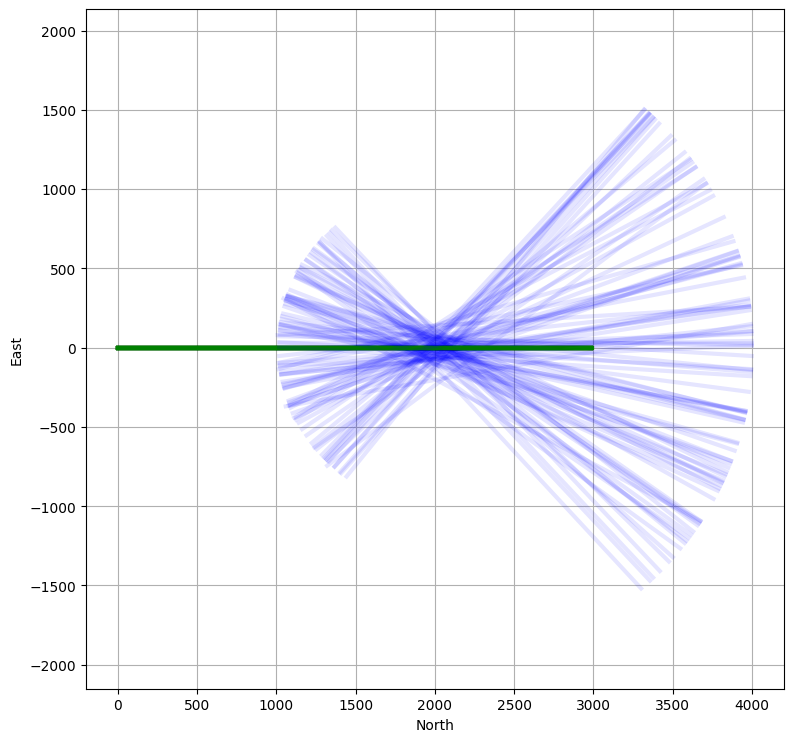

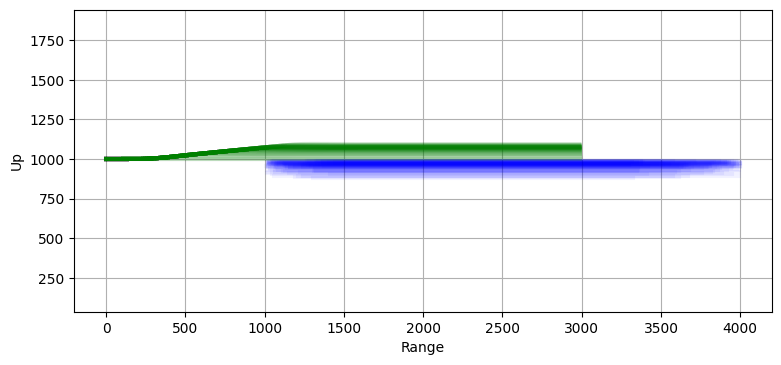

0.6127517223358154


In [12]:
import time
st=time.time()
plt.figure(figsize=(9,9), dpi=100)
for sim_num in range(100):
    plt.plot(res_Y[:,0,sim_num], res_Y[:,1,sim_num], label='player', linewidth=3, alpha=0.1,color='green')
    plt.plot(res_Y[:,3,sim_num], res_Y[:,4,sim_num], label='target', linewidth=3, alpha=0.1,color='blue')
plt.xlabel('North')
plt.ylabel('East')
plt.xlim(-100,4100)
plt.grid(), plt.axis('equal')
plt.show()

plt.figure(figsize=(9,4), dpi=100)
for sim_num in range(100):
    plt.plot(res_Y[:,0,sim_num], -res_Y[:,2,sim_num], label='player', linewidth=3,alpha=0.05,color='green')
    plt.plot(res_Y[:,3,sim_num], -res_Y[:,5,sim_num], label='target', linewidth=3,alpha=0.05,color='blue')
plt.xlabel('Range')
plt.ylabel('Up')
plt.ylim(500,1500)
plt.xlim(-100,4100)
plt.grid(), plt.axis('equal')
plt.show()
print(time.time()-st)

In [13]:
err=0
disy=np.zeros(total_sim)
for i in range (total_sim):
    disy[i]=min(res_Y[:,6,i])
    if min(res_Y[:,6,i])<dist_sep:
        err+=1
print(err)


27


(0.0, 3000.0)

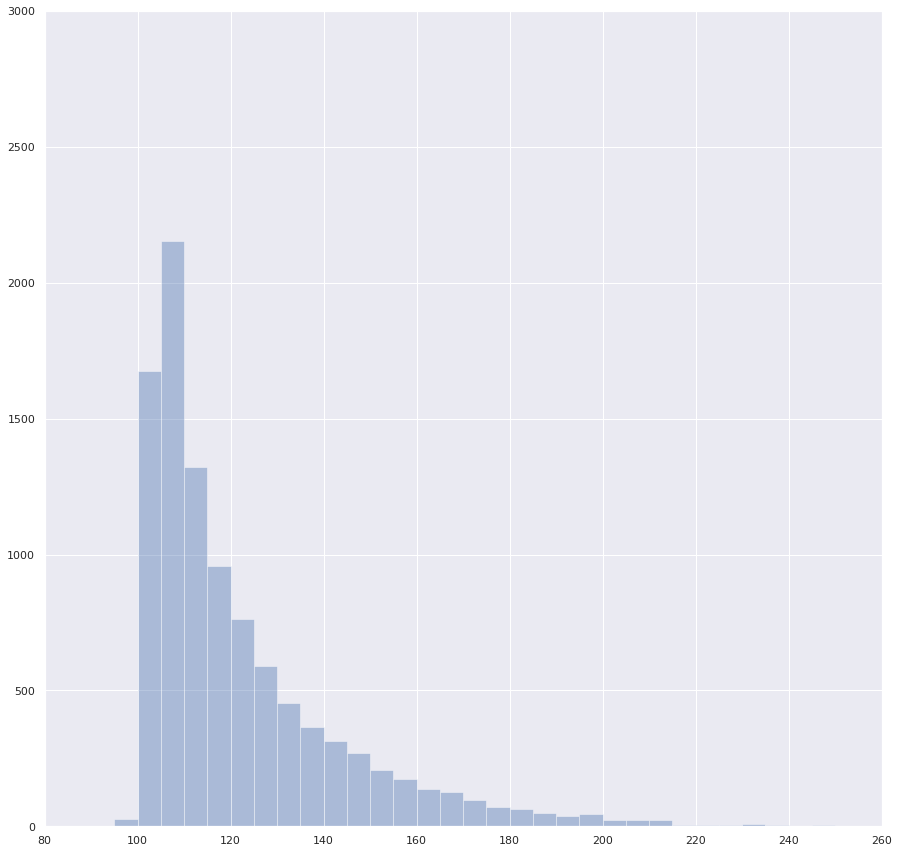

In [14]:
plt.figure(figsize=(15,15))
sns.set(color_codes=True)
sns.distplot(disy, kde=False, hist=True, bins=np.arange(80, 270, 5))
plt.xlim(80,260)
plt.ylim(0,3000)

In [15]:
min(disy)

98.02342304785104

In [16]:
np.mean(disy)

122.20254311696466

In [17]:
np.mean((disy-100)**2)

986.9371379064359